# Column generation approach

## Pre-requisites

In [1]:
import os
from collections import namedtuple
from time import time

import numpy as np
import pandas as pd
from ortools.sat.python import cp_model
from matplotlib import pyplot as plt
from tqdm import tqdm

from src import cg, config, dataset, layers, pack, superitems, utils, warm_start

In [2]:
%matplotlib notebook
%load_ext autoreload
%load_ext nb_black
%autoreload 2

<IPython.core.display.Javascript object>

In [3]:
plt.style.use("seaborn")
np.random.seed(config.RANDOM_SEED)

<IPython.core.display.Javascript object>

## Dataset

In [4]:
product_dataset = dataset.ProductDataset(
    "data/products.pkl",
    config.NUM_PRODUCTS,
    config.MIN_PRODUCT_WIDTH,
    config.MAX_PRODUCT_WIDTH,
    config.MIN_PRODUCT_DEPTH,
    config.MAX_PRODUCT_DEPTH,
    config.MIN_PRODUCT_HEIGHT,
    config.MAX_PRODUCT_HEIGHT,
    config.MIN_PRODUCT_WEIGHT,
    config.MAX_PRODUCT_WEIGHT,
    force_overload=False,
)
product_dataset.products.head()

,width,depth,height,weight,volume
0,160,280,233,8,10438400
1,199,269,260,11,13918060
2,187,101,283,2,5345021
3,126,149,214,2,4017636
4,248,132,280,3,9166080


<IPython.core.display.Javascript object>

In [5]:
ordered_products = 100
order = product_dataset.get_order(ordered_products)
order.head()

,id,width,depth,height,weight,volume
0,121958,193,221,371,2,15824263
1,671155,236,142,437,58,14644744
2,131932,228,139,254,26,8049768
3,365838,267,131,322,11,11262594
4,259178,253,191,580,68,28027340


<IPython.core.display.Javascript object>

In [6]:
order = pd.concat([order.sample(4)] * 5).reset_index(drop=True)
order.head()

,id,width,depth,height,weight,volume
0,191335,245,168,317,2,13047720
1,328947,177,174,226,9,6960348
2,555839,350,287,441,2,44298450
3,256840,187,144,281,12,7566768
4,191335,245,168,317,2,13047720


<IPython.core.display.Javascript object>

In [6]:
order = order.sample(15).reset_index(drop=True)
order["height"] = 400
order.head()

,id,width,depth,height,weight,volume
0,191335,245,168,400,2,13047720
1,328947,177,174,400,9,6960348
2,555839,350,287,400,2,44298450
3,256840,187,144,400,12,7566768
4,486232,218,54,400,2,3143124


<IPython.core.display.Javascript object>

## Martello's lower bounds

In [15]:
utils.get_l0_lb(order, config.PALLET_DIMS)

1.0

<IPython.core.display.Javascript object>

In [16]:
utils.get_l1_lb(order, config.PALLET_DIMS)

(0.0, 0.0, 0.0, 0.0)

<IPython.core.display.Javascript object>

In [40]:
utils.get_l2_lb(order, config.PALLET_DIMS)

  2%|▏         | 4892/240000 [00:28<22:42, 172.59it/s]


KeyboardInterrupt: 

## Superitems

In [7]:
superitems_pool = superitems.SuperitemPool(
    order=order, pallet_dims=config.PALLET_DIMS, max_vstacked=4
)
superitems_pool.to_dataframe()

Generating vertical superitems: 100%|██████████| 31/31 [00:00<00:00, 333393.39it/s]


,width,depth,height,ids,type
0,245,168,317,[0],SingleItemSuperitem
1,177,174,226,[1],SingleItemSuperitem
2,350,287,441,[2],SingleItemSuperitem
3,187,144,281,[3],SingleItemSuperitem
4,245,168,317,[4],SingleItemSuperitem
...,...,...,...,...,...
65,187,348,959,"[1, 3, 5, 9, 13, 17]",VerticalSuperitem
66,187,144,1124,"[7, 11, 15, 19]",VerticalSuperitem
67,245,288,1196,"[0, 3, 4, 7, 11, 15]",VerticalSuperitem
68,350,336,1640,"[2, 6, 8, 10, 12]",VerticalSuperitem


<IPython.core.display.Javascript object>

In [27]:
df = superitems_pool.to_dataframe()
df[df["type"].str.contains("Vertical")]

,width,depth,height,ids,type
35,151,318,610,"[1, 5]",VerticalSuperitem
36,151,318,610,"[9, 13]",VerticalSuperitem
37,214,636,625,"[3, 9, 13]",VerticalSuperitem
38,214,153,640,"[7, 11]",VerticalSuperitem
39,214,153,640,"[15, 19]",VerticalSuperitem
40,214,306,640,"[3, 7, 11, 15]",VerticalSuperitem
41,222,384,744,"[0, 4]",VerticalSuperitem
42,222,384,744,"[8, 12]",VerticalSuperitem
43,288,768,693,"[2, 8, 12]",VerticalSuperitem
44,288,445,642,"[6, 10]",VerticalSuperitem


<IPython.core.display.Javascript object>

In [28]:
df = superitems_pool.to_dataframe()
df[df["type"].str.contains("Horizontal")]

,width,depth,height,ids,type
20,444,384,372,"[0, 4]",TwoHorizontalSuperitemWidth
21,222,768,372,"[0, 4]",TwoHorizontalSuperitemDepth
22,444,384,372,"[8, 12]",TwoHorizontalSuperitemWidth
23,222,768,372,"[8, 12]",TwoHorizontalSuperitemDepth
24,302,318,305,"[1, 5]",TwoHorizontalSuperitemWidth
25,151,636,305,"[1, 5]",TwoHorizontalSuperitemDepth
26,302,318,305,"[9, 13]",TwoHorizontalSuperitemWidth
27,151,636,305,"[9, 13]",TwoHorizontalSuperitemDepth
28,576,445,321,"[2, 6]",TwoHorizontalSuperitemWidth
29,576,445,321,"[10, 14]",TwoHorizontalSuperitemWidth


<IPython.core.display.Javascript object>

## Height groups

In [8]:
height_groups = warm_start.get_height_groups(superitems_pool, height_tol=5)
for group in height_groups:
    display(group.to_dataframe())

,width,depth,height,ids,type
0,177,174,226,[1],SingleItemSuperitem
1,177,174,226,[5],SingleItemSuperitem
2,177,174,226,[9],SingleItemSuperitem
3,177,174,226,[13],SingleItemSuperitem
4,177,174,226,[17],SingleItemSuperitem
5,354,174,226,"[1, 5]",TwoHorizontalSuperitemWidth
6,177,348,226,"[1, 5]",TwoHorizontalSuperitemDepth
7,354,174,226,"[9, 13]",TwoHorizontalSuperitemWidth
8,177,348,226,"[9, 13]",TwoHorizontalSuperitemDepth
9,708,696,226,"[1, 5, 9, 13]",FourHorizontalSuperitem


,width,depth,height,ids,type
0,187,144,281,[3],SingleItemSuperitem
1,187,144,281,[7],SingleItemSuperitem
2,187,144,281,[11],SingleItemSuperitem
3,187,144,281,[15],SingleItemSuperitem
4,187,144,281,[19],SingleItemSuperitem
5,374,144,281,"[3, 7]",TwoHorizontalSuperitemWidth
6,187,288,281,"[3, 7]",TwoHorizontalSuperitemDepth
7,374,144,281,"[11, 15]",TwoHorizontalSuperitemWidth
8,187,288,281,"[11, 15]",TwoHorizontalSuperitemDepth
9,748,576,281,"[3, 7, 11, 15]",FourHorizontalSuperitem


,width,depth,height,ids,type
0,245,168,317,[0],SingleItemSuperitem
1,245,168,317,[4],SingleItemSuperitem
2,245,168,317,[8],SingleItemSuperitem
3,245,168,317,[12],SingleItemSuperitem
4,245,168,317,[16],SingleItemSuperitem
5,490,168,317,"[0, 4]",TwoHorizontalSuperitemWidth
6,245,336,317,"[0, 4]",TwoHorizontalSuperitemDepth
7,490,168,317,"[8, 12]",TwoHorizontalSuperitemWidth
8,245,336,317,"[8, 12]",TwoHorizontalSuperitemDepth
9,980,672,317,"[0, 4, 8, 12]",FourHorizontalSuperitem


,width,depth,height,ids,type
0,350,287,441,[2],SingleItemSuperitem
1,350,287,441,[6],SingleItemSuperitem
2,350,287,441,[10],SingleItemSuperitem
3,350,287,441,[14],SingleItemSuperitem
4,350,287,441,[18],SingleItemSuperitem
5,700,287,441,"[2, 6]",TwoHorizontalSuperitemWidth
6,350,574,441,"[2, 6]",TwoHorizontalSuperitemDepth
7,700,287,441,"[10, 14]",TwoHorizontalSuperitemWidth
8,350,574,441,"[10, 14]",TwoHorizontalSuperitemDepth


,width,depth,height,ids,type
0,177,174,452,"[1, 5]",VerticalSuperitem
1,177,174,452,"[9, 13]",VerticalSuperitem
2,354,174,452,"[1, 5, 9, 13]",VerticalSuperitem


,width,depth,height,ids,type
0,187,348,507,"[3, 9, 13]",VerticalSuperitem
1,748,696,507,"[1, 3, 5, 7, 9, 11, 13, 15]",VerticalSuperitem


,width,depth,height,ids,type
0,187,144,562,"[7, 11]",VerticalSuperitem
1,187,144,562,"[15, 19]",VerticalSuperitem
2,187,288,562,"[3, 7, 11, 15]",VerticalSuperitem
3,374,144,562,"[3, 7, 11, 15]",VerticalSuperitem


,width,depth,height,ids,type
0,245,168,634,"[0, 4]",VerticalSuperitem
1,245,168,634,"[8, 12]",VerticalSuperitem
2,490,168,634,"[0, 4, 8, 12]",VerticalSuperitem


,width,depth,height,ids,type
0,177,174,678,"[1, 5, 9]",VerticalSuperitem


,width,depth,height,ids,type
0,350,336,758,"[2, 8, 12]",VerticalSuperitem


,width,depth,height,ids,type
0,187,348,788,"[3, 7, 9, 13]",VerticalSuperitem


,width,depth,height,ids,type
0,980,696,824,"[0, 1, 3, 4, 5, 7, 8, 9, 11, 12, 13, 15]",VerticalSuperitem


,width,depth,height,ids,type
0,187,144,843,"[11, 15, 19]",VerticalSuperitem


,width,depth,height,ids,type
0,350,287,882,"[6, 10]",VerticalSuperitem
1,350,287,882,"[14, 18]",VerticalSuperitem
2,350,574,882,"[2, 6, 10, 14]",VerticalSuperitem
3,700,287,882,"[2, 6, 10, 14]",VerticalSuperitem
4,245,288,879,"[0, 3, 7, 11, 15]",VerticalSuperitem


,width,depth,height,ids,type
0,354,574,893,"[1, 5, 9, 10, 13, 14]",VerticalSuperitem


,width,depth,height,ids,type
0,177,174,904,"[1, 5, 9, 13]",VerticalSuperitem


,width,depth,height,ids,type
0,245,168,951,"[4, 8, 12]",VerticalSuperitem


,width,depth,height,ids,type
0,187,348,959,"[1, 3, 5, 9, 13, 17]",VerticalSuperitem


,width,depth,height,ids,type
0,374,174,1014,"[1, 3, 5, 7, 9, 11, 13, 15]",VerticalSuperitem


,width,depth,height,ids,type
0,187,144,1124,"[7, 11, 15, 19]",VerticalSuperitem


,width,depth,height,ids,type
0,245,288,1196,"[0, 3, 4, 7, 11, 15]",VerticalSuperitem


,width,depth,height,ids,type
0,350,287,1323,"[2, 6, 10]",VerticalSuperitem


,width,depth,height,ids,type
0,350,336,1640,"[2, 6, 8, 10, 12]",VerticalSuperitem


<IPython.core.display.Javascript object>

In [ ]:
new_height_groups = warm_start.filter_height_groups([height_groups[0]])

## Maxrects

In [35]:
final_layer_pool = layers.LayerPool(superitems.SuperitemPool())
for spool in height_groups:
    layer_pool = warm_start.maxrects(spool, config.PALLET_DIMS, add_single=False)
    final_layer_pool.extend(layer_pool)
final_layer_pool = final_layer_pool.select_layers(
    config.PALLET_WIDTH, config.PALLET_DEPTH, min_density=0.0
)
final_layer_pool.to_dataframe()

Duplicated item in the same layer
Duplicated item in the same layer
Duplicated item in the same layer
Duplicated item in the same layer
Duplicated item in the same layer
Duplicated item in the same layer
Duplicated item in the same layer
Duplicated item in the same layer


,item,x,y,z,width,depth,height,layer
0,1,708,174,0,177,174,226,0
1,5,708,348,0,177,174,226,0
2,9,885,174,0,177,174,226,0
3,13,885,348,0,177,174,226,0


<IPython.core.display.Javascript object>

In [36]:
bin_pool = pack.BinPool(final_layer_pool, config.PALLET_DIMS)
bin_pool.to_dataframe()

Duplicated item in the same layer
Duplicated item in the same layer
Duplicated item in the same layer
Duplicated item in the same layer
Duplicated item in the same layer
Duplicated item in the same layer
Duplicated item in the same layer
Duplicated item in the same layer


,item,x,y,z,width,depth,height,layer,bin
0,1,708,174,0,177,174,226,0,0
1,5,708,348,0,177,174,226,0,0
2,9,885,174,0,177,174,226,0,0
3,13,885,348,0,177,174,226,0,0


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


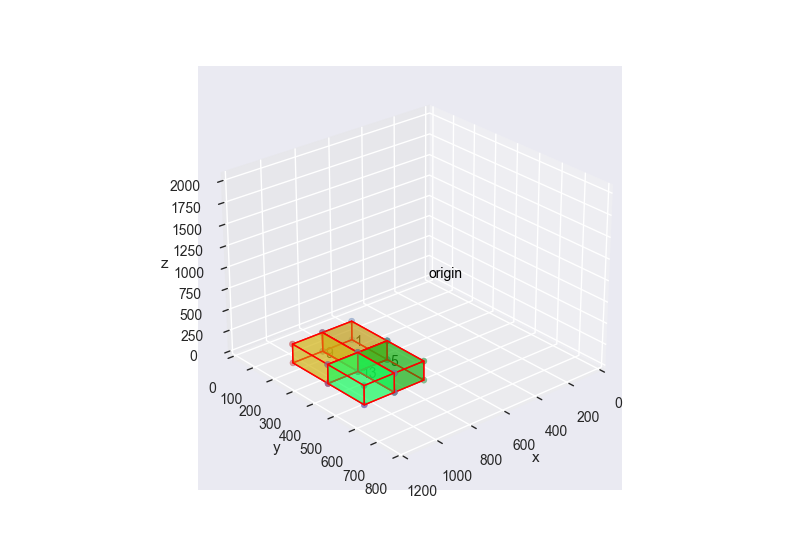

Duplicated item in the same layer
Duplicated item in the same layer
Duplicated item in the same layer
Duplicated item in the same layer
Duplicated item in the same layer
Duplicated item in the same layer
Duplicated item in the same layer
Duplicated item in the same layer


<IPython.core.display.Javascript object>

In [37]:
bin_pool.plot()

## Column generation

- Dobbiamo passare a SP solo gli item con dual > 0?
- Dobbiamo evitare di processare layer con alpha != 1 (anche in SP no placement)?
- RMP lavora su tutti i layer, solo su quelli nuovi o su una parte?

In [ ]:
bins_lbs = []
final_layer_pool = layers.LayerPool(superitems.SuperitemPool())
for spool in height_groups:
    layer_pool = warm_start.maxrects(spool, config.PALLET_DIMS)
    layer_pool, bins_lb = cg.column_generation(
        layer_pool,
        config.PALLET_DIMS,
        max_iter=100,
        tlim=None,
    )
    final_layer_pool.extend(layer_pool)
    bins_lbs.append(bins_lb)
final_layer_pool.to_dataframe()

  3%|▎         | 3/100 [00:00<00:04, 22.70it/s]

Solving RMP...
Duals: [ -0.  -0.  -0. 305.  -0.]
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 1.0]
Solving SP (no placement)...
Reduced cost: 0.0
Reached convergence :)
Solving RMP...
Duals: [ -0.  -0.  -0.  -0.  -0.  -0. 321.  -0. 321.  -0.]
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0]
Solving SP (no placement)...
Reduced cost: -321.0
Solving SP (with placement)...
Solving RMP...
Duals: [ -0. 320.  -0.  -0.  -0.  -0.  -0.   1. 321.  -0.]
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0]
Solving SP (no placement)...
Reduced cost: -321.0
Solving SP (with placement)...
Solving RMP...
Duals: [  1.  -0.  -0.  -0.  -0.  -0.  -0.  -0. 321. 320.]
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0]
Solving SP (no placement)...
Reduced cost: -321.0
Solving SP (with placement)...
Solving RMP...
Duals: [ -0.  -0. 321.  -0.  -0.  -0.  -0.  -0. 321.  -0.]
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0]
So

  6%|▌         | 6/100 [00:00<00:04, 21.99it/s]

Duals: [ -0.  -0.  -0.  -0. 321.  -0.  -0.  -0. 321.  -0.]
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0]
Solving SP (no placement)...
Reduced cost: -321.0
Solving SP (with placement)...
Solving RMP...
Duals: [ -0.  -0.  -0. 320.  -0.   1.  -0.  -0. 321.  -0.]
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]
Solving SP (no placement)...
Reduced cost: -321.0
Solving SP (with placement)...
Solving RMP...
Duals: [ -0.   53.5  53.5  53.5  53.5  -0.   53.5  -0.  267.5  53.5]
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.8333333333333333, 0.0, 0.16666666666666607, 0.16666666666666674, 0.16666666666666674, 0.16666666666666674, 0.16666666666666674, 0.16666666666666674]
RMP: solution not feasible (at least one alpha value is not binary)
Solving SP (no placement)...
Reduced cost: -267.5
Solving SP (with placement)...
Solving RMP...
Duals: [ 80.25  -0.    -0.    -0.    -0.    80.25  80.25  80.25 240

 11%|█         | 11/100 [00:00<00:05, 16.49it/s]

Duals: [ -0.   -0.   -0.   -0.  160.5  -0.   -0.  160.5 160.5  -0. ]
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 0.5]
RMP: solution not feasible (at least one alpha value is not binary)
Solving SP (no placement)...
Reduced cost: -160.5
Solving SP (with placement)...
Solving RMP...
Duals: [ 80.25  80.25  -0.    -0.    80.25  -0.    -0.    80.25 160.5   -0.  ]
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 0.5, 0.0]
RMP: solution not feasible (at least one alpha value is not binary)
Solving SP (no placement)...
Reduced cost: -160.5
Solving SP (with placement)...
Solving RMP...
Duals: [ -0.   -0.   -0.   -0.   -0.   -0.   -0.  160.5 160.5 160.5]
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 0.5, 0.0, 0.0]
RMP: solution not feasible (at least one alpha value is not binary)
Solving SP (no placement)...
Reduced cost: -160.

 15%|█▌        | 15/100 [00:00<00:05, 14.69it/s]

Reduced cost: -160.5
Solving SP (with placement)...
Solving RMP...
Duals: [ -0.   -0.  160.5  -0.   -0.   -0.   -0.  160.5 160.5  -0. ]
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 0.5, 0.0, 0.0, 0.0, 0.0]
RMP: solution not feasible (at least one alpha value is not binary)
Solving SP (no placement)...
Reduced cost: -160.5
Solving SP (with placement)...
Solving RMP...
Duals: [ -0.   -0.   -0.  160.5  -0.   -0.   -0.  160.5 160.5  -0. ]
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0]
RMP: solution not feasible (at least one alpha value is not binary)
Solving SP (no placement)...
Reduced cost: -160.5
Solving SP (with placement)...
Solving RMP...
Duals: [ -0.   -0.   53.5  53.5  53.5  53.5  -0.  107.  160.5  -0. ]
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

 17%|█▋        | 17/100 [00:01<00:06, 13.29it/s]

Duals: [ 80.25  -0.    80.25  -0.    -0.    -0.    -0.    80.25 160.5   80.25]
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
RMP: solution not feasible (at least one alpha value is not binary)
Solving SP (no placement)...
Reduced cost: -160.5
Solving SP (with placement)...
Solving RMP...
Duals: [ 80.25   40.125  -0.     80.25   -0.     40.125  -0.     40.125 160.5
  40.125]
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
RMP: solution not feasible (at least one alpha value is not binary)
Solving SP (no placement)...
Reduced cost: -160.5
Solving SP (with placement)...
Solving RMP...
Duals: [ 98.76923077  24.69230769  74.07692308  -0.          49.38461538
  49.38461538  24.69230769  -0.         148.15384615  -0.        ]
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.46153846153846

 20%|██        | 20/100 [00:03<00:27,  2.93it/s]

Solving RMP...
Duals: [ 2.67500000e+01  5.35000000e+01  8.02500000e+01 -0.00000000e+00
 -3.41060513e-13  2.67500000e+01  5.35000000e+01  8.02500000e+01
  1.33750000e+02 -0.00000000e+00]
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.41666666666666674, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.33333333333333326, 0.16666666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.08333333333333331, 0.08333333333333337, 0.1666666666666666, 0.08333333333333333, 0.08333333333333333]
RMP: solution not feasible (at least one alpha value is not binary)
Solving SP (no placement)...
Reduced cost: -133.7500000000003
Solving SP (with placement)...
Solving RMP...
Duals:

 22%|██▏       | 22/100 [00:05<00:48,  1.61it/s]

 [ 98.76923077  -0.          49.38461538  74.07692308  49.38461538
  -0.          24.69230769  24.69230769 123.46153846  -0.        ]
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.3846153846153847, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.30769230769230776, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.07692307692307691, 0.0, 0.23076923076923064, 0.07692307692307698, 0.15384615384615388, 0.15384615384615388]
RMP: solution not feasible (at least one alpha value is not binary)
Solving SP (no placement)...
Reduced cost: -123.46153846153848
Solving SP (with placement)...
Solving RMP...
Duals: [ 58.36363636  -0.          29.18181818  87.54545455  29.18181818
  58.36363636  58.36363636  -0.         116.72727273  -0.        ]
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.36363636363636365, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2727272727272727, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.09090909090909094, 0.0, 0.1818181818181817, 0.0, 0.18181818181818182, 0.18181818181818182, 0.090909

 23%|██▎       | 23/100 [00:07<01:15,  1.02it/s]

Solving RMP...
Duals: [ 45.85714286  34.39285714  22.92857143  57.32142857  57.32142857
  45.85714286  34.39285714  22.92857143 114.64285714  -0.        ]
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.3571428571428571, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.28571428571428586, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.07142857142857129, 0.0, 0.17857142857142855, 0.035714285714285796, 0.17857142857142855, 0.14285714285714274, 0.07142857142857147, 0.03571428571428581]
RMP: solution not feasible (at least one alpha value is not binary)
Solving SP (no placement)...
Reduced cost: -114.6428571428572
Solving SP (with placement)...


In [55]:
np.floor(np.mean(bins_lbs) / config.max_product_height)

0.0

In [10]:
bin_pool = pack.BinPool(final_layer_pool, config.PALLET_DIMS)
bin_pool.to_dataframe()

LayerPool(layers=[Layer(height=400, ids=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14])])


{0: [Layer(height=400, ids=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14])]}

<IPython.core.display.Javascript object>

In [ ]:
bin_pool.plot()

Todo:
- Come gestire oggetti volanti?
    - Spaziatura spiegata nel paper?
- Suddividere gruppi in piu gruppi
    - Verificare se superitem con stessi item possono essere nello stesso layer (sia in CP che maxrects)
        - Solo fra superitem con > 1 item e superitem con = 1 item
    - Provare superitems orizzontali: stesso item duplicato stesso layer
- Eliminare gruppi con 1 solo item e gruppi con densita minore di 0.5
- Sostituire item rimossi in fase di select_layers con altri item non piazzati, usando maxrects
- Piazzare gli ultimi item con algoritmo s-shape
- Rivedere lower bound martello (L1 viene 0)